<a href="https://colab.research.google.com/github/MarianaWu01/lingyiwu.github.com/blob/main/Outlier_detection_and_fraud_data01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,precision_recall_curve,auc,make_scorer,recall_score,accuracy_score,precision_score,confusion_matrix

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!ls'/content/drive/My Drive/fraudData'

/bin/bash: line 1: ls/content/drive/My Drive/fraudData: No such file or directory


In [17]:
creditcardDF=pd.read_csv('/content/creditcard.csv')
creditcardDF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [18]:
creditcardDF['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [19]:
creditcardDF.shape

(284807, 31)

In [20]:
creditcardDF.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<ipython-input-21-16b1e7f6f4a2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(creditcardDF['Time'])


<Axes: xlabel='Time', ylabel='Density'>

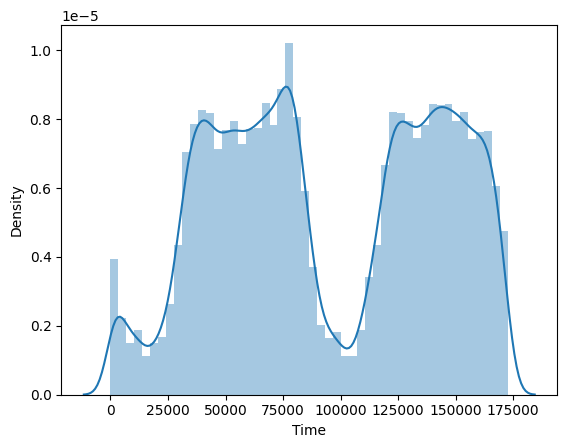

In [21]:
sns.distplot(creditcardDF['Time'])

<ipython-input-22-8bcfe78dec34>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(creditcardDF['Amount'])


<Axes: xlabel='Amount', ylabel='Density'>

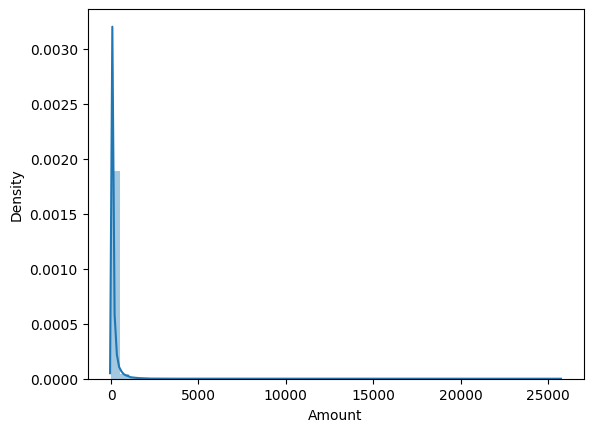

In [22]:
sns.distplot(creditcardDF['Amount'])

In [23]:
creditcardDF['Amount'] = np.log(creditcardDF['Amount']+1)
creditcardDF['Time'] = np.log(creditcardDF['Time']+1)
normal = creditcardDF[creditcardDF['Class']==0]
anomaly = creditcardDF[creditcardDF['Class']==1]
train, small_normal = train_test_split(normal, test_size=0.2, random_state=0)
normal_valid, normal_test = train_test_split(small_normal, test_size=0.5, random_state=0)
anomaly_valid, anomaly_test = train_test_split(anomaly, test_size=0.5, random_state=0)
validation = pd.concat([normal_valid,anomaly_valid])
test = pd.concat([normal_test,anomaly_test])
print(validation.shape)
print(test.shape)
train = train.drop(columns = ['Class']).reset_index(drop=True)
print(train.shape)

(28677, 31)
(28678, 31)
(227452, 30)


In [24]:
featureNames = list(train.columns.values)
valFeatures = validation[featureNames].reset_index(drop= True)
testFeatures = test[featureNames].reset_index(drop= True)

valLabel = validation['Class']
testLabel = test['Class']

In [25]:
valFeatures.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,11.827043,-0.248023,1.259502,-0.993999,-1.587788,1.913462,-0.630270,1.958852,-0.659274,0.002373,...,0.396605,0.089915,0.896611,-0.367547,0.143515,-0.177558,0.025269,0.271419,-0.066416,0.920283
1,10.809566,-1.614505,-0.970137,1.730517,-1.715497,-0.869271,-0.171355,1.216768,-0.031314,0.992762,...,0.831753,0.408654,0.630537,0.382848,-0.110627,0.906539,-0.618206,-0.026364,0.104561,5.874931
2,11.340380,1.106176,0.148096,0.424489,1.282916,-0.080275,0.146526,-0.007108,0.114953,-0.004731,...,-0.148073,-0.042488,0.071593,-0.085294,0.032780,0.637894,-0.331179,0.036130,0.007639,2.866193
3,11.321208,-1.791995,1.102738,0.324217,1.082267,-0.303348,-1.050303,0.066270,0.613586,-0.720545,...,-0.285331,0.151935,0.514245,0.290932,0.403345,-0.064118,-0.318054,0.021940,0.013401,3.432373
4,11.956784,1.924286,0.324362,-0.734639,3.370481,0.783552,1.224944,-0.298881,0.291717,-0.790152,...,-0.227395,-0.022543,-0.115448,0.143200,-0.357497,-0.109288,-0.105516,-0.025440,-0.050761,2.572612


In [26]:
validation['Class'].value_counts()

Class
0    28431
1      246
Name: count, dtype: int64

In [27]:
test['Class'].value_counts()

Class
0    28432
1      246
Name: count, dtype: int64

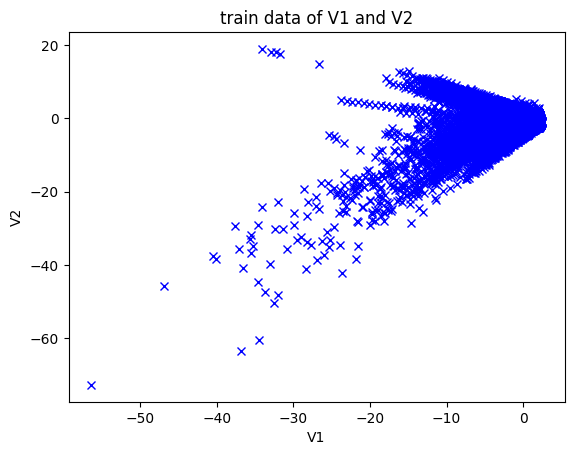

In [28]:
plt.figure()
plt.title("train data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(train.iloc[:, 1],train.iloc[:,2],"bx")
plt.show()

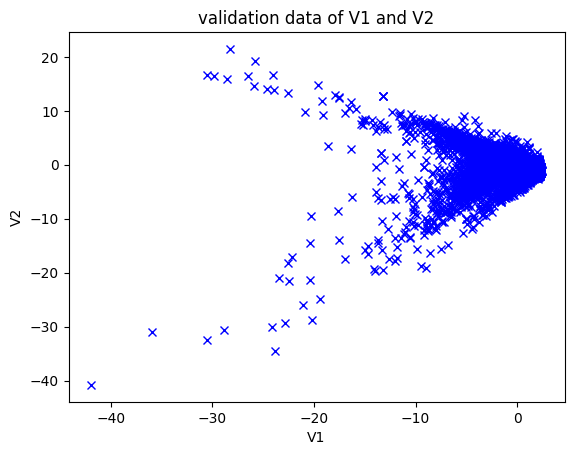

In [29]:
plt.figure()
plt.title("validation data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(validation.iloc[:, 1],validation.iloc[:,2],"bx")
plt.show()

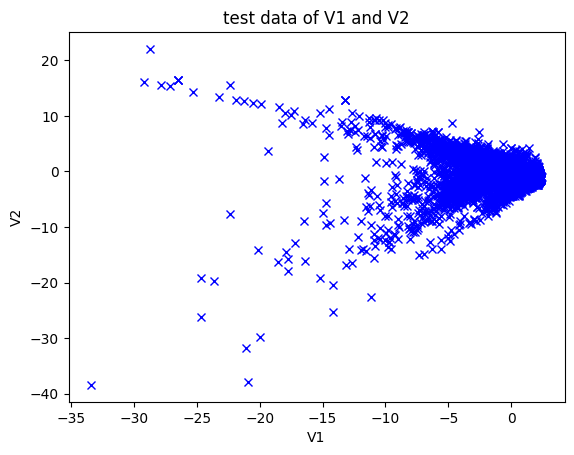

In [30]:
plt.figure()
plt.title("test data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(test.iloc[:, 1],test.iloc[:,2],"bx")
plt.show()

In [31]:
np.arange(1,20,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

In [32]:
def estimateGaussian(dataset):
  mu = np.mean(dataset,axis = 0)
  sigma = np.cov(dataset.T)
  return mu,sigma

In [34]:
np.linspace(1,21,10,endpoint = False)

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

In [35]:
mu,sigma = estimateGaussian(train)
model = multivariate_normal(mean = mu,cov = sigma,allow_singular = True)

In [36]:
pdfVal = model.pdf(valFeatures)
print(max(pdfVal))
print(min(pdfVal))

p_val = model.logpdf(valFeatures)
print(max(p_val))
print(min(p_val))

3.936022689245927e-12
0.0
-26.260850372210967
-7554.270217704669


In [37]:
p = model.logpdf(train)
print(p.shape)
print((p_val.shape))

(227452,)
(28677,)


In [38]:
print(p_val)
print(p_val < -500)

[  -31.28574735   -34.94205051   -27.79402451 ... -5175.93656039
 -4545.5057626    -29.7152192 ]
[False False False ...  True  True False]


In [39]:
[[1],[2],[3]]

[[1], [2], [3]]

In [40]:
scores = []
p_val = model.logpdf(valFeatures)
thresholds = np.linspace(min(p_val),max(p_val),200)

for threshold in thresholds:
  y_pred = (p_val<threshold).astype(int)
  scores.append([recall_score(valLabel, y_pred),
                precision_score(valLabel, y_pred),
                f1_score(valLabel, y_pred, average = "binary")])

scores = np.array(scores)
maxIndex = scores[...,2].ravel().argmax()#maxIndex of the 3rd column (f1_score) #193, #.ravel return a flattened array
bestThreshold = thresholds[maxIndex]
print(scores.shape)#each row is a pair of (recall, precision, f1) corresponding to a threshold

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(200, 3)


In [41]:
print(scores)

[[0.         0.         0.        ]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01

In [42]:
print(maxIndex)
print(bestThreshold)

193
-253.23600717620593


In [43]:
np.mean(train.iloc[:,1])

0.00524675542006222

In [44]:
mu[1]

0.00524675542006222

In [45]:
print(mu)

Time      11.252384
V1         0.005247
V2        -0.005416
V3         0.010293
V4        -0.008144
V5         0.004281
V6         0.001813
V7         0.010354
V8        -0.001103
V9         0.006351
V10        0.009573
V11       -0.007736
V12        0.009943
V13        0.001084
V14        0.010816
V15        0.001082
V16        0.007216
V17        0.012364
V18        0.003412
V19       -0.001811
V20       -0.001092
V21       -0.001302
V22       -0.000354
V23        0.000209
V24        0.000288
V25        0.000375
V26        0.000457
V27       -0.000509
V28       -0.000119
Amount     3.152259
dtype: float64


In [46]:
y_test_pred_raw = model.logpdf(testFeatures)
y_pred_test = y_test_pred_raw < bestThreshold

f1_score(testLabel, y_pred_test, average = "binary")

0.7401574803149606

In [47]:
y_pred_test

array([False, False, False, ...,  True, False,  True])

In [48]:
predoutliersTest = np.asarray(np.where(y_pred_test))
len(predoutliersTest[0])

262

In [49]:
predoutliersTest

array([[  248,   437,   605,  1007,  1353,  1451,  1462,  1546,  1988,
         2461,  3674,  3928,  4216,  4928,  5144,  5846,  5975,  6022,
         6682,  6706,  6858,  7017,  7138,  8267,  8452,  8611,  8677,
         8936,  8996,  9207,  9443,  9807,  9988, 10263, 10391, 10657,
        11224, 12205, 13539, 13935, 14050, 14573, 14579, 14802, 14869,
        15740, 16061, 16888, 17322, 17663, 19352, 19902, 20680, 20800,
        21748, 22366, 22552, 22859, 23217, 23456, 23742, 24639, 24819,
        25654, 25678, 26035, 27282, 27293, 27314, 27587, 27723, 28117,
        28178, 28396, 28432, 28433, 28434, 28435, 28436, 28437, 28438,
        28440, 28443, 28444, 28445, 28446, 28447, 28449, 28450, 28453,
        28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462,
        28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471,
        28472, 28473, 28475, 28479, 28480, 28481, 28482, 28483, 28484,
        28486, 28487, 28490, 28492, 28493, 28494, 28496, 28497, 28498,
      

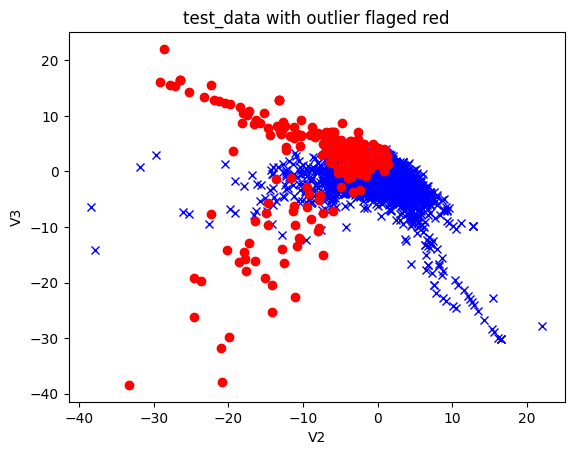

In [50]:
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V2")
plt.ylabel("V3")
plt.plot(testFeatures.iloc[:, 2],testFeatures.iloc[:,3],"bx")
plt.plot(testFeatures.iloc[predoutliersTest[0],1],testFeatures.iloc[predoutliersTest[0],2],"ro")
plt.show()

In [51]:
print("%s: %r" % ("accuracy_score is: ", accuracy_score(testLabel, y_pred_test)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(testLabel, y_test_pred_raw)))#correction: should be y_pred_test instead of y_test_pred_raw
print("%s: %r" % ("f1_score is: ", f1_score(testLabel, y_pred_test )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(testLabel, y_pred_test)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9953971685612665
roc_auc_score is: : 0.03898289914947546
f1_score is: : 0.7401574803149606
confusion_matrix is: 
        pred_0  pred_1
true_0   28358      74
true_1      58     188
recall = 0.7642276422764228
precision = 0.7175572519083969


In [52]:
IFModel = IsolationForest(random_state=0, contamination = 0.01, n_estimators = 200, max_features = 2).fit(train)
IFModel#（isolate normal and inormal）

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_features=2, n_estimators=200,
                random_state=0)

In [53]:
def convert(x):
  if x == 1:
    return 0
  else:
    return 1
pred = IFModel.predict(testFeatures) #1 for inliers, -1 for outliers.
pred2 = list(map(convert, pred))
# pred2
import collections

counter=collections.Counter(pred2)
print(counter)#

f1_score(testLabel, pred2, average = "binary")#0.48 when added parameters

Counter({0: 28283, 1: 395})


0.48049921996879874